# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.322069
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *With random initialized weights, the probabiliy is 1/num_classes.*


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.935123 analytic: 0.935123, relative error: 8.586158e-08
numerical: 1.369005 analytic: 1.369005, relative error: 1.247248e-08
numerical: 1.818041 analytic: 1.818041, relative error: 1.219751e-08
numerical: -0.385294 analytic: -0.385294, relative error: 8.307696e-08


numerical: -1.812229 analytic: -1.812229, relative error: 3.403812e-08
numerical: 5.744992 analytic: 5.744992, relative error: 1.065844e-08
numerical: 0.801841 analytic: 0.801841, relative error: 7.158332e-08
numerical: 1.070890 analytic: 1.070890, relative error: 9.978208e-08


numerical: 0.114191 analytic: 0.114191, relative error: 4.673433e-07
numerical: 2.834226 analytic: 2.834226, relative error: 4.101885e-08
numerical: -1.747672 analytic: -1.753763, relative error: 1.739653e-03
numerical: -0.072804 analytic: -0.065128, relative error: 5.564986e-02


numerical: 0.151030 analytic: 0.153618, relative error: 8.494628e-03
numerical: -1.214386 analytic: -1.223889, relative error: 3.897166e-03
numerical: -2.687833 analytic: -2.689574, relative error: 3.236850e-04
numerical: 2.920852 analytic: 2.927033, relative error: 1.057060e-03


numerical: 0.676569 analytic: 0.677227, relative error: 4.856380e-04
numerical: 2.008660 analytic: 2.001171, relative error: 1.867676e-03
numerical: -4.267586 analytic: -4.271544, relative error: 4.634522e-04
numerical: 0.535882 analytic: 0.531105, relative error: 4.476864e-03


In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we                  did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.322069e+00 computed in 0.060646s
vectorized loss: 2.322069e+00 computed in 0.008349s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
learning_rates = np.random.rand(15)*(learning_rates[1]-learning_rates[0]) + learning_rates[0]
regularization_strengths = [2.5e4, 5e4]
regularization_strengths = np.random.rand(15)*(regularization_strengths[1]-regularization_strengths[0]) + regularization_strengths[0]

################################################################################
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        sm = Softmax()
        loss_hist = sm.train(X_train, y_train, learning_rate=lr, reg=rs,
                              num_iters=1500, verbose=False)
        # Write the LinearSVM.predict function and evaluate the performance on both the
        # training and validation set
        y_train_pred = sm.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        print('training accuracy: {}'.format(training_accuracy))
        y_val_pred = sm.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        print('validation accuracy: {}'.format(validation_accuracy))
        results[(lr, rs)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = sm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

training accuracy: 0.3298979591836735
validation accuracy: 0.345


training accuracy: 0.33840816326530615
validation accuracy: 0.362


training accuracy: 0.33983673469387754
validation accuracy: 0.353


training accuracy: 0.3340612244897959
validation accuracy: 0.346


training accuracy: 0.3370612244897959
validation accuracy: 0.354


training accuracy: 0.34038775510204083
validation accuracy: 0.353


training accuracy: 0.33585714285714285
validation accuracy: 0.348


training accuracy: 0.3310612244897959
validation accuracy: 0.34


training accuracy: 0.3302040816326531
validation accuracy: 0.352


training accuracy: 0.33738775510204083
validation accuracy: 0.346


training accuracy: 0.3503265306122449
validation accuracy: 0.377


training accuracy: 0.32940816326530614
validation accuracy: 0.343


training accuracy: 0.3472857142857143
validation accuracy: 0.36


training accuracy: 0.33679591836734696
validation accuracy: 0.355


training accuracy: 0.3341224489795918
validation accuracy: 0.354


training accuracy: 0.33891836734693875
validation accuracy: 0.342


training accuracy: 0.34877551020408165
validation accuracy: 0.357


training accuracy: 0.3385918367346939
validation accuracy: 0.339


training accuracy: 0.324
validation accuracy: 0.337


training accuracy: 0.3409387755102041
validation accuracy: 0.36


training accuracy: 0.33524489795918366
validation accuracy: 0.353


training accuracy: 0.33591836734693875
validation accuracy: 0.341


training accuracy: 0.3310408163265306
validation accuracy: 0.347


training accuracy: 0.3390408163265306
validation accuracy: 0.354


training accuracy: 0.33610204081632655
validation accuracy: 0.352


training accuracy: 0.34244897959183673
validation accuracy: 0.365


training accuracy: 0.3325102040816327
validation accuracy: 0.342


training accuracy: 0.34722448979591836
validation accuracy: 0.366


training accuracy: 0.347734693877551
validation accuracy: 0.361


training accuracy: 0.32271428571428573
validation accuracy: 0.34


training accuracy: 0.3220204081632653
validation accuracy: 0.357


training accuracy: 0.34520408163265304
validation accuracy: 0.356


training accuracy: 0.3311224489795918
validation accuracy: 0.336


training accuracy: 0.33016326530612244
validation accuracy: 0.349


training accuracy: 0.34314285714285714
validation accuracy: 0.356


training accuracy: 0.33414285714285713
validation accuracy: 0.362


training accuracy: 0.33316326530612245
validation accuracy: 0.343


training accuracy: 0.3200612244897959
validation accuracy: 0.344


training accuracy: 0.331
validation accuracy: 0.354


training accuracy: 0.33046938775510204
validation accuracy: 0.332


training accuracy: 0.34091836734693876
validation accuracy: 0.344


training accuracy: 0.33322448979591834
validation accuracy: 0.338


training accuracy: 0.35046938775510206
validation accuracy: 0.359


training accuracy: 0.34451020408163263
validation accuracy: 0.36


training accuracy: 0.3336734693877551
validation accuracy: 0.349


training accuracy: 0.3354489795918367
validation accuracy: 0.357


training accuracy: 0.34285714285714286
validation accuracy: 0.358


training accuracy: 0.3410204081632653
validation accuracy: 0.349


training accuracy: 0.3314285714285714
validation accuracy: 0.35


training accuracy: 0.3406326530612245
validation accuracy: 0.356


training accuracy: 0.33240816326530614
validation accuracy: 0.348


training accuracy: 0.3323469387755102
validation accuracy: 0.357


training accuracy: 0.32824489795918366
validation accuracy: 0.351


training accuracy: 0.3283877551020408
validation accuracy: 0.348


training accuracy: 0.32993877551020406
validation accuracy: 0.346


training accuracy: 0.3486530612244898
validation accuracy: 0.364


training accuracy: 0.32212244897959186
validation accuracy: 0.333


training accuracy: 0.34483673469387754
validation accuracy: 0.363


training accuracy: 0.33991836734693875
validation accuracy: 0.354


training accuracy: 0.3290612244897959
validation accuracy: 0.346


training accuracy: 0.33279591836734695
validation accuracy: 0.347


training accuracy: 0.34677551020408165
validation accuracy: 0.361


training accuracy: 0.34085714285714286
validation accuracy: 0.349


training accuracy: 0.32348979591836735
validation accuracy: 0.341


training accuracy: 0.34251020408163263
validation accuracy: 0.357


training accuracy: 0.3325918367346939
validation accuracy: 0.349


training accuracy: 0.3296938775510204
validation accuracy: 0.345


training accuracy: 0.3307551020408163
validation accuracy: 0.34


training accuracy: 0.3296530612244898
validation accuracy: 0.335


training accuracy: 0.32512244897959186
validation accuracy: 0.346


training accuracy: 0.3466734693877551
validation accuracy: 0.362


training accuracy: 0.33255102040816326
validation accuracy: 0.344


training accuracy: 0.34891836734693876
validation accuracy: 0.362


training accuracy: 0.34814285714285714
validation accuracy: 0.356


training accuracy: 0.3343265306122449
validation accuracy: 0.351


training accuracy: 0.33379591836734696
validation accuracy: 0.332


training accuracy: 0.34722448979591836
validation accuracy: 0.357


training accuracy: 0.33761224489795916
validation accuracy: 0.342


training accuracy: 0.3325714285714286
validation accuracy: 0.357


training accuracy: 0.34316326530612246
validation accuracy: 0.35


training accuracy: 0.3300408163265306
validation accuracy: 0.341


training accuracy: 0.324734693877551
validation accuracy: 0.324


training accuracy: 0.31848979591836735
validation accuracy: 0.334


training accuracy: 0.32816326530612244
validation accuracy: 0.348


training accuracy: 0.335
validation accuracy: 0.358


training accuracy: 0.335265306122449
validation accuracy: 0.352


training accuracy: 0.3331224489795918
validation accuracy: 0.341


training accuracy: 0.3526938775510204
validation accuracy: 0.372


training accuracy: 0.33946938775510205
validation accuracy: 0.359


training accuracy: 0.3256938775510204
validation accuracy: 0.348


training accuracy: 0.33410204081632655
validation accuracy: 0.351


training accuracy: 0.3450408163265306
validation accuracy: 0.361


training accuracy: 0.3370204081632653
validation accuracy: 0.356


training accuracy: 0.32624489795918366
validation accuracy: 0.346


training accuracy: 0.3445918367346939
validation accuracy: 0.361


training accuracy: 0.330734693877551
validation accuracy: 0.34


training accuracy: 0.32477551020408163
validation accuracy: 0.34


training accuracy: 0.3252857142857143
validation accuracy: 0.345


training accuracy: 0.33410204081632655
validation accuracy: 0.351


training accuracy: 0.3343469387755102
validation accuracy: 0.349


training accuracy: 0.3470408163265306
validation accuracy: 0.362


training accuracy: 0.33040816326530614
validation accuracy: 0.355


training accuracy: 0.34353061224489795
validation accuracy: 0.358


training accuracy: 0.34551020408163263
validation accuracy: 0.356


training accuracy: 0.32787755102040816
validation accuracy: 0.338


training accuracy: 0.3348979591836735
validation accuracy: 0.352


training accuracy: 0.3502448979591837
validation accuracy: 0.368


training accuracy: 0.33748979591836736
validation accuracy: 0.35


training accuracy: 0.33385714285714285
validation accuracy: 0.344


training accuracy: 0.34110204081632656
validation accuracy: 0.356


training accuracy: 0.3283673469387755
validation accuracy: 0.338


training accuracy: 0.3247551020408163
validation accuracy: 0.34


training accuracy: 0.3286530612244898
validation accuracy: 0.334


training accuracy: 0.329265306122449
validation accuracy: 0.346


training accuracy: 0.3320612244897959
validation accuracy: 0.342


training accuracy: 0.3492857142857143
validation accuracy: 0.367


training accuracy: 0.33279591836734695
validation accuracy: 0.347


training accuracy: 0.3450612244897959
validation accuracy: 0.367


training accuracy: 0.33861224489795916
validation accuracy: 0.35


training accuracy: 0.3302857142857143
validation accuracy: 0.34


training accuracy: 0.3302040816326531
validation accuracy: 0.349


training accuracy: 0.3501020408163265
validation accuracy: 0.363


training accuracy: 0.3385714285714286
validation accuracy: 0.35


training accuracy: 0.33187755102040817
validation accuracy: 0.343


training accuracy: 0.33824489795918367
validation accuracy: 0.354


training accuracy: 0.3370204081632653
validation accuracy: 0.354


training accuracy: 0.3309795918367347
validation accuracy: 0.357


training accuracy: 0.33085714285714285
validation accuracy: 0.343


training accuracy: 0.33493877551020407
validation accuracy: 0.355


training accuracy: 0.3273469387755102
validation accuracy: 0.349


training accuracy: 0.3421224489795918
validation accuracy: 0.358


training accuracy: 0.3363469387755102
validation accuracy: 0.343


training accuracy: 0.34522448979591835
validation accuracy: 0.356


training accuracy: 0.34508163265306124
validation accuracy: 0.353


training accuracy: 0.329734693877551
validation accuracy: 0.339


training accuracy: 0.32981632653061227
validation accuracy: 0.345


training accuracy: 0.3454285714285714
validation accuracy: 0.356


training accuracy: 0.33824489795918367
validation accuracy: 0.349


training accuracy: 0.3287551020408163
validation accuracy: 0.343


training accuracy: 0.34077551020408164
validation accuracy: 0.361


training accuracy: 0.33448979591836736
validation accuracy: 0.345


training accuracy: 0.32893877551020406
validation accuracy: 0.346


training accuracy: 0.32581632653061227
validation accuracy: 0.343


training accuracy: 0.3252040816326531
validation accuracy: 0.337


training accuracy: 0.334265306122449
validation accuracy: 0.355


training accuracy: 0.34055102040816326
validation accuracy: 0.35


training accuracy: 0.3296530612244898
validation accuracy: 0.34


training accuracy: 0.3471020408163265
validation accuracy: 0.357


training accuracy: 0.34581632653061223
validation accuracy: 0.36


training accuracy: 0.3295102040816327
validation accuracy: 0.341


training accuracy: 0.33777551020408164
validation accuracy: 0.343


training accuracy: 0.34110204081632656
validation accuracy: 0.351


training accuracy: 0.33746938775510205
validation accuracy: 0.353


training accuracy: 0.333265306122449
validation accuracy: 0.344


training accuracy: 0.32932653061224487
validation accuracy: 0.34


training accuracy: 0.3312040816326531
validation accuracy: 0.341


training accuracy: 0.32757142857142857
validation accuracy: 0.34


training accuracy: 0.3335918367346939
validation accuracy: 0.347


training accuracy: 0.33171428571428574
validation accuracy: 0.341


training accuracy: 0.3352040816326531
validation accuracy: 0.343


training accuracy: 0.34548979591836737
validation accuracy: 0.362


training accuracy: 0.3334285714285714
validation accuracy: 0.349


training accuracy: 0.3426530612244898
validation accuracy: 0.36


training accuracy: 0.3416734693877551
validation accuracy: 0.349


training accuracy: 0.32971428571428574
validation accuracy: 0.341


training accuracy: 0.32683673469387753
validation accuracy: 0.332


training accuracy: 0.34914285714285714
validation accuracy: 0.354


training accuracy: 0.33483673469387754
validation accuracy: 0.346


training accuracy: 0.32855102040816325
validation accuracy: 0.342


training accuracy: 0.3423265306122449
validation accuracy: 0.345


training accuracy: 0.33308163265306123
validation accuracy: 0.346


training accuracy: 0.32881632653061227
validation accuracy: 0.33


training accuracy: 0.3264285714285714
validation accuracy: 0.34


training accuracy: 0.32457142857142857
validation accuracy: 0.338


training accuracy: 0.3322857142857143
validation accuracy: 0.346


training accuracy: 0.3414285714285714
validation accuracy: 0.348


training accuracy: 0.33214285714285713
validation accuracy: 0.351


training accuracy: 0.3493265306122449
validation accuracy: 0.356


training accuracy: 0.3399795918367347
validation accuracy: 0.352


training accuracy: 0.32412244897959186
validation accuracy: 0.332


training accuracy: 0.33022448979591834
validation accuracy: 0.345


training accuracy: 0.34485714285714286
validation accuracy: 0.36


training accuracy: 0.33079591836734695
validation accuracy: 0.346


training accuracy: 0.3348163265306122
validation accuracy: 0.348


training accuracy: 0.3419795918367347
validation accuracy: 0.356


training accuracy: 0.33510204081632655
validation accuracy: 0.349


training accuracy: 0.3294489795918367
validation accuracy: 0.347


training accuracy: 0.3338979591836735
validation accuracy: 0.343


training accuracy: 0.3299183673469388
validation accuracy: 0.351


training accuracy: 0.3323673469387755
validation accuracy: 0.344


training accuracy: 0.3436326530612245
validation accuracy: 0.347


training accuracy: 0.32940816326530614
validation accuracy: 0.346


training accuracy: 0.3529387755102041
validation accuracy: 0.37


training accuracy: 0.3432857142857143
validation accuracy: 0.359


training accuracy: 0.3362040816326531
validation accuracy: 0.35


training accuracy: 0.335734693877551
validation accuracy: 0.353


training accuracy: 0.3481836734693878
validation accuracy: 0.364


training accuracy: 0.3326122448979592
validation accuracy: 0.347


training accuracy: 0.32783673469387753
validation accuracy: 0.346


training accuracy: 0.3410612244897959
validation accuracy: 0.354


training accuracy: 0.331734693877551
validation accuracy: 0.337


training accuracy: 0.3269591836734694
validation accuracy: 0.346


training accuracy: 0.3251428571428571
validation accuracy: 0.34


training accuracy: 0.33510204081632655
validation accuracy: 0.352


training accuracy: 0.3342857142857143
validation accuracy: 0.344


training accuracy: 0.350265306122449
validation accuracy: 0.369


training accuracy: 0.3343469387755102
validation accuracy: 0.352


training accuracy: 0.3439795918367347
validation accuracy: 0.349


training accuracy: 0.338
validation accuracy: 0.351


training accuracy: 0.3243469387755102
validation accuracy: 0.337


training accuracy: 0.3333673469387755
validation accuracy: 0.353


training accuracy: 0.3437142857142857
validation accuracy: 0.359


training accuracy: 0.33983673469387754
validation accuracy: 0.353


training accuracy: 0.3356326530612245
validation accuracy: 0.342


training accuracy: 0.3375102040816326
validation accuracy: 0.348


training accuracy: 0.33524489795918366
validation accuracy: 0.354


training accuracy: 0.3249183673469388
validation accuracy: 0.338


training accuracy: 0.32542857142857146
validation accuracy: 0.332


training accuracy: 0.33491836734693875
validation accuracy: 0.347


training accuracy: 0.3307551020408163
validation accuracy: 0.338


training accuracy: 0.3388775510204082
validation accuracy: 0.358


training accuracy: 0.33546938775510204
validation accuracy: 0.353


training accuracy: 0.3503673469387755
validation accuracy: 0.351


training accuracy: 0.3416734693877551
validation accuracy: 0.356


training accuracy: 0.33010204081632655
validation accuracy: 0.339
lr 1.117619e-07 reg 2.824828e+04 train accuracy: 0.343531 val accuracy: 0.358000
lr 1.117619e-07 reg 2.960077e+04 train accuracy: 0.347041 val accuracy: 0.362000
lr 1.117619e-07 reg 2.989070e+04 train accuracy: 0.345041 val accuracy: 0.361000
lr 1.117619e-07 reg 3.109552e+04 train accuracy: 0.345510 val accuracy: 0.356000
lr 1.117619e-07 reg 3.358019e+04 train accuracy: 0.344592 val accuracy: 0.361000
lr 1.117619e-07 reg 3.797445e+04 train accuracy: 0.337020 val accuracy: 0.356000
lr 1.117619e-07 reg 4.309701e+04 train accuracy: 0.334347 val accuracy: 0.349000
lr 1.117619e-07 reg 4.319350e+04 train accuracy: 0.334102 val accuracy: 0.351000
lr 1.117619e-07 reg 4.364597e+04 train accuracy: 0.334102 val accuracy: 0.351000
lr 1.117619e-07 reg 4.370060e+04 train accuracy: 0.330408 val accuracy: 0.355000
lr 1.117619e-07 reg 4.376429e+04 train accuracy: 0.330735 val accuracy: 0.340000
lr 1.117619e-07 reg 4.497673e+04 train accu

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.361000


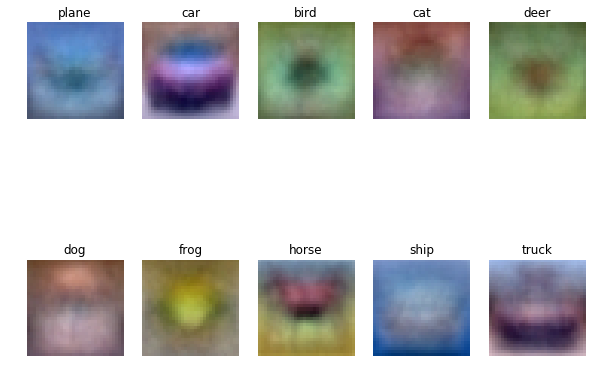

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])